In [16]:
from datascience import Table
import csv
import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')


# Data-driven Analysis of NBA Draft Adages
---
## Objective
---
Every year, the teams in the NBA draft amateur players with the hope that they will become future star players. Over the years, many widely held assumptions have formed about which types of players to draft. This project will take a closer statistical look at these adages and try to conclude if they are legitimate or merely myth.

## Data
---
I collected data from two main sources.

1) I downloaded all draft data from Basketball Reference from the years 1990-2015. An appropriate subset will be used for each analysis. 
2) stats.nba.com has a wealth of NBA Combine measurements. This anthropometric data is at the core of some of these draft adages. 

The `draft_data` table includes summary statistics on all drafted players that do a good job describing how a player has performed over their career.

The `anthro_data` table includes measurements of NBA prospects taken pre-draft, including height, weight, body fat percentage, wingspan, standing reach, etc.

In [135]:
draft_data = None

for i in range(1991, 2016):
    with open('data/drafts/draft_NBA_' + str(i) + '_stats.csv', 'rt', encoding='ascii') as f:
        reader = csv.reader(f)
        j = 0
        for row in reader:
            if j == 0 and i == 1991:
                draft_data = Table(['Year'] + row)
            elif j != 0:
                draft_data = draft_data.with_row([str(i)] + row)
            j += 1
            
anthro_data = None

for i in range(2000, 2012):
    with open('data/combines/anthro_' + str(i) + '.csv', 'rt', encoding='ascii') as f:
        reader = csv.reader(f)
        j = 0
        for row in reader:
            if j == 0 and i == 2000:
                anthro_data = Table(['Year'] + row)
            else:
                if row[5] != 'POSITION':
                    anthro_data = anthro_data.with_row([str(i)] + row)
                else:
                    j-=1
            j += 1

In [136]:
draft_data

Year,Rk,Pk,Tm,Player,College,Yrs,G,MP,PTS,TRB,AST,FG%,3P%,FT%,WS,WS/48,BPM,VORP
1991,1,1,CHH,Larry Johnson,University of Nevada Las Vegas,10,707,25685,11450,5300,2298,.484,.332,.766,36.3,16.2,7.5,3.3
1991,2,2,NJN,Kenny Anderson,Georgia Institute of Technology,14,858,25868,10789,2641,5196,.421,.346,.790,30.1,12.6,3.1,6.1
1991,3,3,SAC,Billy Owens,Syracuse University,10,600,17619,7026,4016,1704,.481,.291,.629,29.4,11.7,6.7,2.8
1991,4,4,DEN,Dikembe Mutombo,Georgetown University,18,1196,36791,11729,12359,1240,.518,.000,.684,30.8,9.8,10.3,1.0
1991,5,5,MIA,Steve Smith,Michigan State University,14,942,28855,13430,3060,2922,.440,.358,.845,30.6,14.3,3.2,3.1
1991,6,6,DAL,Doug Smith,University of Missouri,5,296,5833,2356,1234,400,.425,.083,.773,19.7,8.0,4.2,1.4
1991,7,7,MIN,Luc Longley,University of New Mexico,10,567,12006,4090,2794,836,.462,.000,.760,21.2,7.2,4.9,1.5
1991,8,8,DEN,Mark Macon,Temple University,6,251,5018,1685,467,428,.384,.270,.735,20.0,6.7,1.9,1.7
1991,9,9,ATL,Stacey Augmon,University of Nevada Las Vegas,15,1001,21658,7990,3216,1561,.469,.152,.728,21.6,8.0,3.2,1.6
1991,10,10,ORL,Bison Dele,University of Arizona,8,413,10004,4536,2564,440,.528,.143,.691,24.2,11.0,6.2,1.1


In [137]:
anthro_data

Year,TEMP_PLAYER_ID,PLAYER_ID,FIRST_NAME,LAST_NAME,PLAYER_NAME,POSITION,HEIGHT_WO_SHOES,HEIGHT_WO_SHOES_FT_IN,HEIGHT_W_SHOES,HEIGHT_W_SHOES_FT_IN,WEIGHT,WINGSPAN,WINGSPAN_FT_IN,STANDING_REACH,STANDING_REACH_FT_IN,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH
2000,,2124,Malik,Allen,Malik Allen,PF-C,80.25,6' 8.25'',,,271,86.5,7' 2.5'',109.0,9' 1'',,,
2000,,12019,Harold,Arceneaux,Harold Arceneaux,SG-SF,76.5,6' 4.5'',,,219,80.5,6' 8.5'',103.0,8' 7'',,,
2000,,12020,Lamont,Barnes,Lamont Barnes,PF-C,80.5,6' 8.5'',,,235.5,87.5,7' 3.5'',108.0,9' 0'',,,
2000,,12131,Mario,Bland,Mario Bland,PF,77.5,6' 5.5'',,,287,84.0,7' 0'',103.0,8' 7'',,,
2000,,2056,Primoz,Brezec,Primoz Brezec,C,84.75,7' 0.75'',,,243,86.0,7' 2'',110.0,9' 2'',,,
2000,,2081,Ernest,Brown,Ernest Brown,C,82.0,6' 10'',,,222.5,85.25,7' 1.25'',109.5,9' 1.5'',,,
2000,,2049,Speedy,Claxton,Speedy Claxton,PG,70.5,5' 10.5'',,,166,72.0,6' 0'',94.5,7' 10.5'',,,
2000,,12132,Eric,Coley,Eric Coley,SG-SF,76.0,6' 4'',,,205,83.0,6' 11'',102.0,8' 6'',,,
2000,,12133,Ed,Cota,Ed Cota,PG,72.25,6' 0.25'',,,189,76.0,6' 4'',96.5,8' 0.5'',,,
2000,,12134,Schea,Cotton,Schea Cotton,SF,76.25,6' 4.25'',,,219.5,79.0,6' 7'',100.0,8' 4'',,,


## Summary
---
Anthropometric data is pretty important. Perhaps we'd like to see the average 'size' of players at each position. 

In [138]:
anthro_data = anthro_data.where(anthro_data.column("HEIGHT_WO_SHOES") != "")
anthro_data['BMI'] = np.divide(anthro_data.apply(lambda x: float(x),'WEIGHT'), (anthro_data.apply(lambda x: float(x)*float(x),'HEIGHT_WO_SHOES')))*703


### Centers
---
What does an incoming NBA Center look like?

In [139]:
centers = anthro_data.where("POSITION", "C")
# bigs_a.append(anthro_data.where("POSITION", "PF-C"))
# bigs_a.append(anthro_data.where("POSITION", "PF"))
centers = centers.select(['HEIGHT_WO_SHOES', 'WEIGHT'])

print('An incoming NBA Center is on average ' + str(np.mean(centers.column(0).astype(np.float))) + ' inches tall.')
print('An incoming NBA Center is on average ' + str(np.mean(centers.column(1).astype(np.float))) + ' pounds heavy.')

An incoming NBA Center is on average 82.7318181818 inches tall.
An incoming NBA Center is on average 256.567272727 pounds heavy.


## Visualization
---
A key component to any analysis of draft adages is to quantify how good each pick turns out to be. Here we create a scatter plot and a corresponding line of best fit to describe the expected WS/48_% (win shares per 48 mins as a percentage of the entire draft class' win shares per 48 mins) for each pick in the draft. 

Pk,Year,Player,Tm,WS/48,WS/48 sum,WS/48_%,WS/48_z,WS/48_z mean,WS/48_z_ae,Career Status,Spurs
1,1991,Larry Johnson,CHH,16.2,308.9,0.0524442,1.99906,2.11349,-0.11443,Met,False
1,1992,Shaquille O'Neal,ORL,23.7,368,0.0644022,3.45863,2.11349,1.34514,Exceeded,False
1,1993,Chris Webber,ORL,20.7,303.5,0.0682043,2.8748,2.11349,0.761309,Exceeded,False
1,1994,Glenn Robinson,MIL,20.7,311.7,0.06641,2.8748,2.11349,0.761309,Exceeded,False
1,1995,Joe Smith,GSW,10.9,324.3,0.0336109,0.967636,2.11349,-1.14586,Bad,False
1,1996,Allen Iverson,PHI,26.7,368.9,0.0723773,4.04245,2.11349,1.92896,Far Exceeded,False
1,1997,Tim Duncan,SAS,19,337.1,0.0563631,2.54397,2.11349,0.430474,Met,True
1,1998,Michael Olowokandi,LAC,8.3,411.5,0.0201701,0.461654,2.11349,-1.65184,Bust,False
1,1999,Elton Brand,CHI,15.9,341,0.0466276,1.94068,2.11349,-0.172813,Met,False
1,2000,Kenyon Martin,NJN,12.3,313.9,0.0391845,1.24009,2.11349,-0.873404,Bad,False


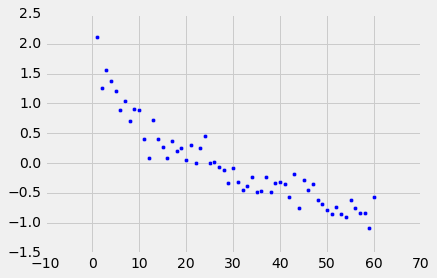

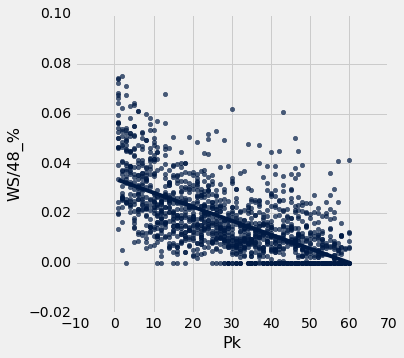

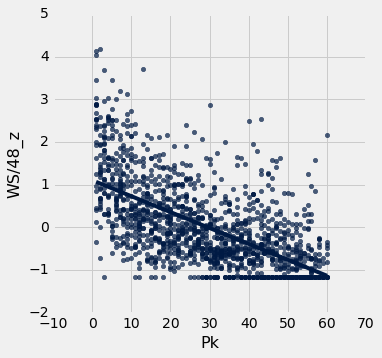

In [242]:
def to_int(s):
    return int(s)

win_shares = draft_data.select(['Year','Pk', 'Player', 'Tm', 'WS/48']).sort('Pk')
pk = win_shares.apply(to_int, 'Pk')
win_shares['Pk'] = pk.astype(np.float)

ws = win_shares.column('WS/48')
ws[ws == ''] = 0
win_shares['WS/48'] = ws.astype(np.float)

win_shares_sum_by_year = win_shares.group('Year', np.sum)
win_shares_min_by_year = win_shares.group('Year', np.min)

win_shares = win_shares.join('Year', win_shares_sum_by_year).select(['Year', 'Player', 'Pk', 'Tm', 'WS/48', 'WS/48 sum'])
win_shares = win_shares.with_column('WS/48_%', win_shares.column(4) / win_shares.column(5))

# win_shares_sum_by_year.show(1)
# win_shares_min_by_year.show(1)
u = np.mean(win_shares.column('WS/48'))
stdev = np.std(win_shares.column('WS/48'))

win_shares['WS/48_z'] = (win_shares.column('WS/48') - u) / stdev

z = win_shares.select(['Pk', 'WS/48_z']).group('Pk', np.mean)
win_shares = win_shares.join('Pk', z)
plt.scatter(z.column(0), z.column(1))

win_shares['WS/48_z_ae'] = (win_shares.column('WS/48_z') - win_shares.column('WS/48_z mean'))


def career_status(ws):
    status = ''
    if ws < -1.5:
        status = 'Bust'
    elif ws >= -1.5 and ws < -.5:
        status = 'Bad'
    elif ws >= -.5 and ws < .5:
        status = 'Met'
    elif ws >= .5 and ws < 1.5:
        status = 'Exceeded'
    else:
        status = 'Far Exceeded'

    return status

v_career_status = np.vectorize(career_status)
win_shares['Career Status'] = v_career_status(win_shares.column('WS/48_z_ae'))

win_shares['Spurs'] = win_shares['Tm'] == 'SAS'

win_shares.show(20)

win_shares.select(['Pk', 'WS/48_%']).scatter('Pk', overlay=True, fit_line=True)
win_shares.select(['Pk', 'WS/48_z']).scatter('Pk', overlay=True, fit_line=True)

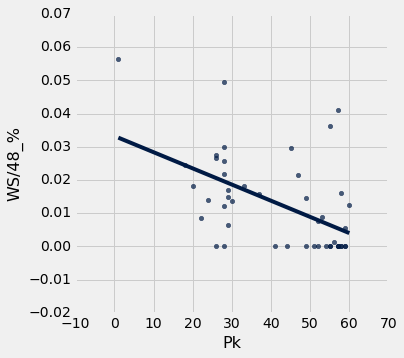

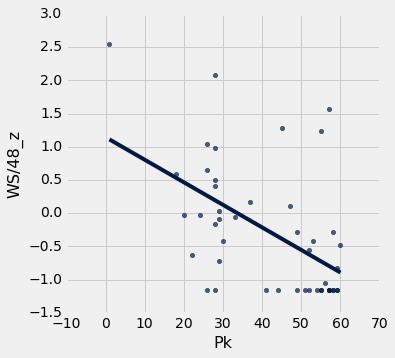

In [234]:
# win_shares.select(['Pk', 'WS/48_%']).scatter('Pk', overlay=True, fit_line=True)
# spurs = draft_data.where('Tm', 'SAS').join('Year', win_shares) \
#     .select(['Year', 'Pk', 'Tm', 'Player', 'WS/48', 'WS/48 sum', 'WS/48_%', 'WS/48_z', 'WS/48_z mean', 'WS/48_z_ae'])

spurs = draft_data.where('Tm', 'SAS').join('Player', win_shares)

ws = spurs.column('WS/48')
ws[ws == ''] = 0
spurs['WS/48'] = ws.astype(np.float)

pk = spurs.apply(to_int, 'Pk')
spurs['Pk'] = pk.astype(np.int)

# spurs['WS/48_%'] = spurs.column('WS/48') / spurs.column('WS/48 sum')
# spurs['WS/48_z'] = (spurs.column('WS/48') - u) / stdev

spurs.select(['Pk', 'WS/48_%']).scatter('Pk', overlay=True, fit_line=True)
spurs.select(['Pk', 'WS/48_z']).scatter('Pk', overlay=True, fit_line=True)

# spurs.show()

In [235]:
not_spurs = draft_data.where( \
    draft_data.column('Tm') \
    != 'SAS').join('Player', win_shares) 

pk = not_spurs.apply(to_int, 'Pk')
not_spurs['Pk'] = pk.astype(np.float)

ws = not_spurs.column('WS/48')
ws[ws == ''] = 0
not_spurs['WS/48'] = ws.astype(np.float)

not_spurs['WS/48_%'] = not_spurs.column('WS/48') / not_spurs.column('WS/48 sum')
not_spurs['WS/48_z'] = (not_spurs.column('WS/48') - u) / stdev
not_spurs.show(1)

spurs_z_avg = sum(spurs.column('WS/48_z_ae')) / len(spurs.column('WS/48_z_ae'))
not_spurs_z_avg = sum(not_spurs.column('WS/48_z_ae')) / len(not_spurs.column('WS/48_z_ae'))
everyone_z_avg = sum(win_shares.column('WS/48_z_ae')) / len(win_shares.column('WS/48_z_ae'))
spurs_vs_everyone = Table(['Team', 'WS/48_z_ae']).with_rows([
    ["Spurs", spurs_z_avg],
    ["Everyone", not_spurs_z_avg]
])
spurs_vs_everyone


Player,Year,Rk,Pk,Tm,College,Yrs,G,MP,PTS,TRB,AST,FG%,3P%,FT%,WS,WS/48,BPM,VORP,Pk_2,Year_2,Tm_2,WS/48_2,WS/48 sum,WS/48_%,WS/48_z,WS/48_z mean,WS/48_z_ae,Bust,Bad,Met,Exceeded,Far Exceeded
A.J. Bramlett,1999,39,39,CLE,University of Arizona,1,8,61,8,22,0,.190,,,7.6,1,2.8,0.0,39,1999,CLE,1,341,0.00293255,-0.95899,-0.324566,-0.634424,False,True,False,False,False


Team,WS/48_z_ae
Spurs,0.132349
Everyone,-0.00232751


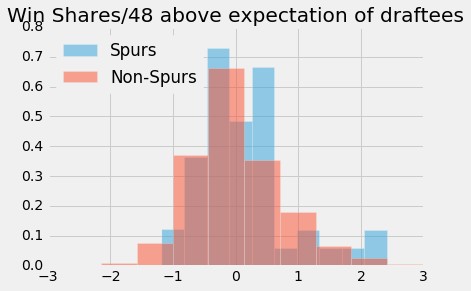

In [236]:
def plot_ws_z_ae(table1, table2, subject):
    """
    Draws a histogram of the WS/48_z_ae column in the given table.
    """
    spurs_draftees = table1.column('WS/48_z_ae') 
    non_spurs_draftees = table2.column('WS/48_z_ae') 
    
    plt.hist(spurs_draftees, alpha=.5, normed=True, label='Spurs')
    plt.hist(non_spurs_draftees, alpha=.5, normed=True, label='Non-Spurs')
    plt.legend(loc='upper left')
    plt.title("Win Shares/48 above expectation of " + subject)
    plt.show()

plot_ws_z_ae(spurs, not_spurs, 'draftees')


In [246]:
career = win_shares.pivot('Spurs', 'Career Status')
career.show()

proportions = Table().with_columns([
        "Career Status", career.column("Career Status"),
        "Spurs", career.column('True')/sum(career.column('True')),
        "Non-Spurs", career.column('False')/sum(career.column('False'))
    ])
proportions.show()

Career Status,False,True
Bad,316,7
Bust,10,0
Exceeded,231,6
Far Exceeded,56,4
Met,795,29


Career Status,Spurs,Non-Spurs
Bad,0.152174,0.224432
Bust,0,0.00710227
Exceeded,0.130435,0.164062
Far Exceeded,0.0869565,0.0397727
Met,0.630435,0.564631


In [262]:
# test_statistic between the two distributions in the sample
s = proportions.column('Spurs')
ns = proportions.column('Non-Spurs')
def test_statistic(s, ns):
    return (s[4] - ns[4]) + (s[3] - ns[3]) + (s[2] - ns[2]) + (ns[1] - s[1]) + (ns[0] - s[0])

observed_statistic = test_statistic(s, ns)
observed_statistic

0.15872035573122534

In [273]:
shuffled = win_shares.select('Career Status').sample()

# Construct a table in which career status has been shuffled
players_with_shuffled_career = Table().with_columns([
        "Spurs", win_shares.column('Spurs'),
        "Career Status", win_shares.column('Career Status'),
        "Career Status (shuffled)", shuffled.column('Career Status')
    ])
players_with_shuffled_career

Spurs,Career Status,Career Status (shuffled)
False,Met,Bad
False,Exceeded,Bad
False,Exceeded,Bad
False,Exceeded,Met
False,Bad,Met
False,Far Exceeded,Bad
True,Met,Bad
False,Bust,Met
False,Met,Bad
False,Bad,Bad


In [274]:
career_shuffled = players_with_shuffled_career.pivot('Spurs', 'Career Status (shuffled)')
career_shuffled

Career Status (shuffled),False,True
Bad,310,13
Bust,10,0
Exceeded,229,8
Far Exceeded,58,2
Met,801,23


In [275]:
# TVD between the two distributions in the contingency table above
c_s = career_shuffled
s = c_s.column('True')/sum(c_s.column('True'))
ns = c_s.column('False')/sum(c_s.column('False'))

test_statistic(s, ns)

-0.1106719367588932

0.094

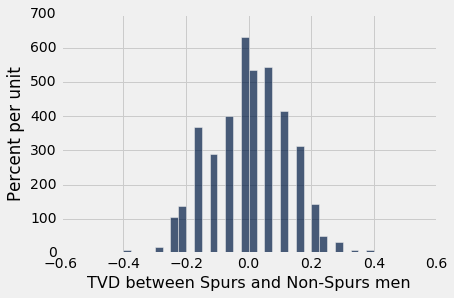

In [284]:
repetitions = 500

tvds = Table().with_column("TVD between Spurs and Non-Spurs men", [])

for i in np.arange(repetitions):
    # Construct a permuted table
    shuffled = win_shares.select('Career Status').sample()
    # Construct a table in which career status has been shuffled
    players_with_shuffled_career = Table().with_columns([
        "Spurs", win_shares.column('Spurs'),
        "Career Status", win_shares.column('Career Status'),
        "Career Status (shuffled)", shuffled.column('Career Status')
    ])
    career_shuffled = players_with_shuffled_career.pivot('Spurs', 'Career Status (shuffled)')

    # Compute TVD
    c_s = career_shuffled
    s = c_s.column('True')/sum(c_s.column('True'))
    ns = c_s.column('False')/sum(c_s.column('False'))
    tvds.append([test_statistic(s, ns)])

tvds.hist(bins=np.arange(-0.5, 0.5, 0.025))

empirical_p_value = np.count_nonzero(tvds.column(0) >= observed_statistic) / tvds.num_rows
empirical_p_value